In [1]:
import requests
import gzip
import pandas as pd
import networkx as nx
import numpy as np

%matplotlib inline
import seaborn as sns

import sys
sys.path = ['/cellar/users/mikeyu/DeepTranslate/ddot'] + sys.path

import ddot
from ddot import Ontology, nx_to_NdexGraph, read_term_descriptions, ndex_to_sim_matrix, expand_seed, melt_square, align_hierarchies, parse_ndex_uuid

# Setup parameters

In [2]:
ndex_server = 'http://test.ndexbio.org'
ndex_user = 'mikeyu_testacct3'
ndex_pass = 'GoHejVeg8'

In [3]:
alpha = 0.1
beta = 0.5

In [4]:
seed = ['FANCA','FANCB', 'FANCC', 'BRCA2', 'FANCD2', 'FANCE',
        'FANCF', 'FANCG', 'FANCI', 'BRIP1', 'FANCL', 'FANCM', 'PALB2', 'RAD51C', 'SLX4', 'ERCC4', 'RAD51',
        'BRCA1', 'UBE2T', 'XRCC2']

In [5]:
similarity_uuid = 'd2dfa5cc-56de-11e7-a2e2-0660b7976219'

# Download similarity data from NDEx

In [6]:
%time tmp = np.load('/cellar/users/mikeyu/DeepTranslate/hnexo/RFv2r3_square.npz')
rf, rf_genes = tmp['rf'], tmp['genes']
np.fill_diagonal(rf, 0)
rf[np.isnan(rf)] = 0
sim, sim_names = rf, rf_genes

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.27 ms


In [7]:
# sim, sim_names = ndex_to_sim_matrix(
#     similarity_uuid,
#     ndex_server,
#     ndex_user,
#     ndex_pass,
#     similarity='similarity',
#     input_fmt='cx_matrix',
#     output_fmt='matrix',
#     subset=None)

# Expand known FA genes

min_sim: 5.20081410586


246

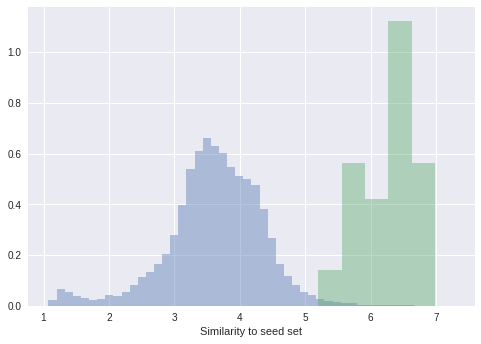

In [8]:
expand, expand_idx, sim_2_seed, fig = expand_seed(
    seed,
    sim,
    sim_names,
    agg='mean',
    min_sim=4,
    filter_perc=None,
    seed_perc=0,
    agg_perc=None,
    expand_size=None,
    figure=True,
)
expand = list(expand)
len(expand)

# Run CLIXO

In [9]:
df_sq = pd.DataFrame(sim[expand_idx, :][:, expand_idx], index=expand, columns=expand)
df = melt_square(df_sq)
ont = Ontology.run_clixo(df, alpha, beta)

temp output: /tmp/tmpJTFRFH
temp graph: /tmp/tmpRohPqV
temp output log: /tmp/tmp9eGWhV
/tmp/tmpRohPqV	0.1	0.5	-10000000 2017-08-16 16:40:15.893267
CLIXO command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/mhk7-clixo_0.3-cec3674/clixo /tmp/tmpRohPqV 0.1 0.5 | awk '{if ( $1 ~ /^#/ ) {print "\#", strftime("%Y-%m-%d %H:%M:%S"), $0 ; fflush() } else {print $0}}' | tee /tmp/tmp9eGWhV
Extracting by grep -v # 2017-08-16 16:40:17.111531
Elapsed time (sec): 1.21526622772 2017-08-16 16:40:17.161358
Ontology: 246 genes, 38 terms, 290 gene-term relations, 38 term-term relations
node_attributes: 
edge_attributes: CLIXO_score


In [10]:
# ont.to_pickle('/cellar/users/mikeyu/tmp.pkl')
ont = Ontology.read_pickle('/cellar/users/mikeyu/tmp.pkl')

# Align with Gene Ontology

## Read Gene Ontology from NDEx

In [10]:
go_human = Ontology.from_ndex(ddot.config.GO_HUMAN_URL)
print go_human.summary()


Changing node_attr index name from None to 'Node'
Changing edge_attr index names from [None, None] to ['Child', 'Parent']
18770 genes, 19277 terms, 212312 gene-term relations, 42961 term-term relations
node_attributes: entrez_gene, name, isRoot, Branch, Label, ensembl_gene, uniprot, Term_Description, Gene_or_Term, Size
edge_attributes: Is_Tree_Edge, EdgeType


In [12]:
# go_human.to_pickle('/cellar/users/mikeyu/go.pkl')
go_human = Ontology.read_pickle('/cellar/users/mikeyu/go.pkl')

## Do alignment

In [11]:
alignment = ont.align(go_human, 100, 40, update_self=['Term_Description', 'Size'], update_ref=False)

collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmpPBedKe
collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmpsovirw
Alignment command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/alignOntology/calculateFDRs /tmp/tmpZW7AOg /tmp/tmpOj49Bg 0.05 criss_cross /tmp/tmpcQhMa0 100 40 gene


# Annotate which genes are seeds and which genes have drug targets

In [12]:
pharos, pharos_nodes = ndex_to_sim_matrix(
    parse_ndex_uuid(ddot.config.PHAROS_URL),
    similarity=None,
    input_fmt='cx',
    output_fmt='sparse',
    ndex_server=ndex_server, ndex_user=ndex_user, ndex_pass=ndex_pass)
pharos.rename(columns={'Node1' : 'gene', 'Node2' : 'drug'}, inplace=True)
gene_drug = pharos.groupby('gene').agg({'drug' : lambda x : ','.join(x)})
gene_drug['has_drug'] = True

ont.update_node_attr(gene_drug)

In [13]:
seed_set = set(seed)
seed_attr = pd.DataFrame({'Seed' : [g in seed_set for g in ont.genes]}, index=ont.genes)
ont.update_node_attr(seed_attr)

In [14]:
def make_label(x):
    if pd.isnull(x['Aligned_Term_Description']):
        return x.name
    else:
        return '%s\n%s' % (x.name, x['Aligned_Term_Description'])
    
ont.node_attr = ont.node_attr.reindex(set(ont.genes) | set(ont.terms))
ont.node_attr['Label'] = ont.node_attr.apply(make_label, axis=1)

# Upload Ontology to NDEx (to be viewed by Kei's Hierarchical Viewer)

In [15]:
name = 'Fanconi Anemia Gene Ontology (FanGO)'
description = (
    'Data-driven ontology created by CLIXO '
    '(parameters: alpha={alpha}, beta={beta}). '
    'Created from similarity network '
    'at {ndex_server}/{ndex_uuid}').format(
        alpha=alpha,
        beta=beta,
        ndex_server=ndex_server,
        ndex_uuid=similarity_uuid)

ont_url, ont_ndexgraph = ont.to_ndex(
    name=name,
    description=description,
    sim=df,
    features=['similarity'],
    public=True,
    subnet_max_term_size=10,
)

print ont_url

# nx.write_graphml(ont_ndexgraph, '/cellar/users/mikeyu/tmp.graphml')

http://dev2.ndexbio.org/v2/network/65b4250f-82dc-11e7-9743-0660b7976219
